 # ML Model
 
 This notebook is to create and train a tensorflow model to recognize pictures of the sky as different weather conditions

# New Section

In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import glob

Mounted at /content/drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_path = '/content/drive/MyDrive/dataset2'

data_dir = pathlib.Path(data_path)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


766


This is the first image of clouds to signify cludy skies

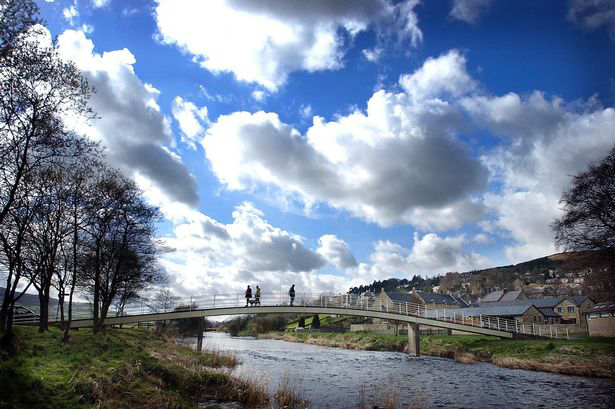

In [5]:
clouds = list(data_dir.glob('clouds/*'))
PIL.Image.open(str(clouds[0]))

We break it up into batch size 32 with 240x240px pictures to try to hit a balance between high resolution enough to be accurate but small enough to quickly train the model

In [6]:
batch_size = 32
img_height = 240
img_width = 240

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 768 files belonging to 3 classes.
Using 615 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 768 files belonging to 3 classes.
Using 153 files for validation.


these are the 3 different classifications of weather that this dataset will provide training for

In [8]:
class_names = train_ds.class_names
print(class_names)

['clouds', 'rain', 'sunshine']


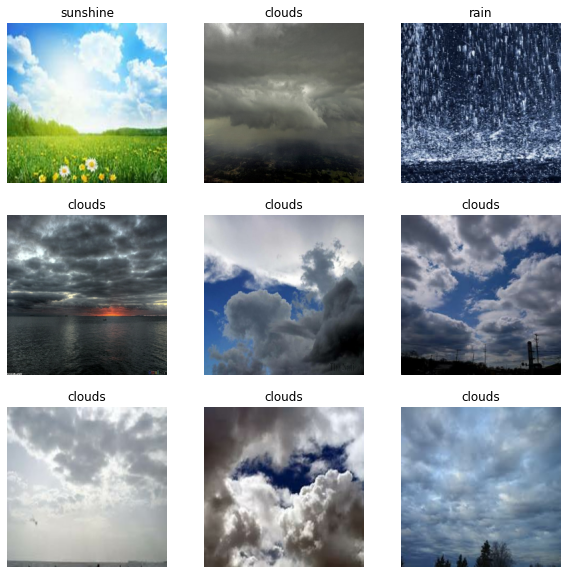

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

double checking the batch dimensions

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 240, 240, 3)
(32,)


this is precaching pictures to speed up the model

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

we rescale the color info to be 0-1 in place of 0-255 to allow for better training

In [12]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## WHat does this do?

In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 240, 240, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 240, 240, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 120, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        1

In [15]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
20/20 [==============================] - 68s 3s/step - loss: 2.1716 - accuracy: 0.4260 - val_loss: 0.9678 - val_accuracy: 0.5752
Epoch 2/20
20/20 [==============================] - 33s 2s/step - loss: 0.7353 - accuracy: 0.7057 - val_loss: 0.8378 - val_accuracy: 0.7451
Epoch 3/20
20/20 [==============================] - 33s 2s/step - loss: 0.5444 - accuracy: 0.7837 - val_loss: 0.6127 - val_accuracy: 0.7647
Epoch 4/20
20/20 [==============================] - 34s 2s/step - loss: 0.4262 - accuracy: 0.8341 - val_loss: 0.6573 - val_accuracy: 0.7386
Epoch 5/20
20/20 [==============================] - 34s 2s/step - loss: 0.3530 - accuracy: 0.8650 - val_loss: 0.6991 - val_accuracy: 0.7320
Epoch 6/20
20/20 [==============================] - 33s 2s/step - loss: 0.2179 - accuracy: 0.9268 - val_loss: 0.5449 - val_accuracy: 0.8627
Epoch 7/20
20/20 [==============================] - 33s 2s/step - loss: 0.1548 - accuracy: 0.9545 - val_loss: 0.7919 - val_accuracy: 0.8170
Epoch 8/20
20/20 [==

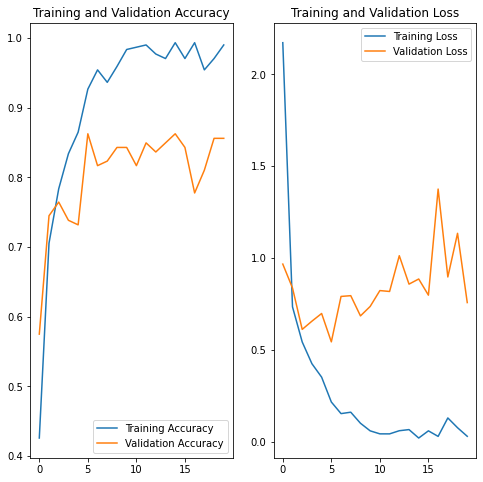

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
Weather_model_trained = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)




In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

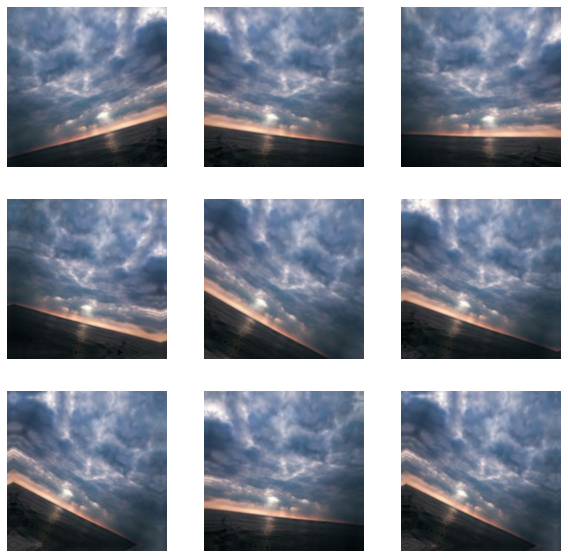

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [20]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 240, 240, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 240, 240, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 240, 240, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 120, 120, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                  

In [23]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
20/20 [==============================] - 41s 2s/step - loss: 1.6262 - accuracy: 0.4943 - val_loss: 1.1673 - val_accuracy: 0.5686
Epoch 2/15
20/20 [==============================] - 38s 2s/step - loss: 0.8137 - accuracy: 0.6520 - val_loss: 1.1800 - val_accuracy: 0.5490
Epoch 3/15
20/20 [==============================] - 38s 2s/step - loss: 0.6773 - accuracy: 0.7106 - val_loss: 0.6691 - val_accuracy: 0.7451
Epoch 4/15
20/20 [==============================] - 39s 2s/step - loss: 0.5045 - accuracy: 0.7821 - val_loss: 0.7371 - val_accuracy: 0.7386
Epoch 5/15
20/20 [==============================] - 39s 2s/step - loss: 0.4599 - accuracy: 0.8098 - val_loss: 0.5639 - val_accuracy: 0.7908
Epoch 6/15
20/20 [==============================] - 39s 2s/step - loss: 0.4275 - accuracy: 0.8309 - val_loss: 0.8718 - val_accuracy: 0.7255
Epoch 7/15
20/20 [==============================] - 39s 2s/step - loss: 0.4263 - accuracy: 0.8309 - val_loss: 0.5389 - val_accuracy: 0.7974
Epoch 8/15
20/20 [==

In [ ]:
model.save('Weather_prediction_model.h5')

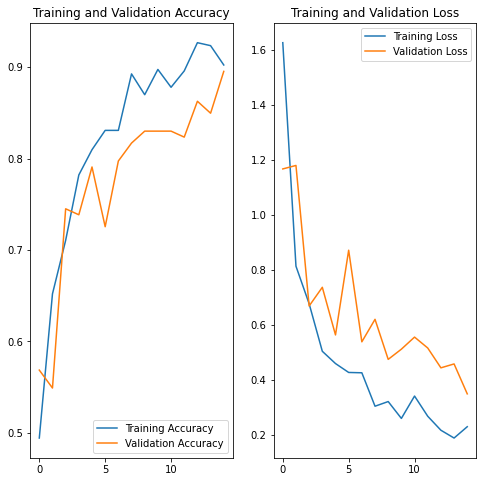

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [32]:
url = "https://images.unsplash.com/photo-1633467189683-9c84b2eed802?crop=entropy&cs=tinysrgb&fm=jpg&ixlib=rb-1.2.1&q=80&raw_url=true&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2067"

path = tf.keras.utils.get_file('crop&w=2067', origin=url)

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

319488/310277 [==============================] - 0s 0us/step
This image most likely belongs to sunshine with a 73.07 percent confidence.


In [34]:
url = "https://images.unsplash.com/photo-1534088568595-a066f410bcda?crop=entropy&cs=tinysrgb&fm=jpg&ixlib=rb-1.2.1&q=80&raw_url=true&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=751"

path = tf.keras.utils.get_file('crop&w=751', origin=url)

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

81920/68045 [====================================] - 0s 0us/step
This image most likely belongs to clouds with a 99.76 percent confidence.


In [ ]:
model.save('augmented_data_weather_model.h5')